In [1]:
import os, json
from pathlib import Path
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt


In [2]:
BASE_DIR = Path("/Users/apple/Documents/Computational Neuroscience Paris Saclay/Supervised projects/main/code")
RAW  = BASE_DIR / "data/raw"
PROC = BASE_DIR / "data/processed"

TS_path = RAW / "TS_ADR.npy"
dt = 2.4  # TR seconds

# Use the SAME DK68 structural matrix you used everywhere else (synthetic + network-SINDy)
W_path = PROC / "W_syn_DK68.npy"   # (68,68)

OUT_DIR = PROC / "real_fmri_network_sindy_out_DK68"
OUT_DIR.mkdir(parents=True, exist_ok=True)

print("TS_path:", TS_path)
print("W_path :", W_path)
print("OUT_DIR:", OUT_DIR)
print("dt(TR):", dt)


TS_path: /Users/apple/Documents/Computational Neuroscience Paris Saclay/Supervised projects/main/code/data/raw/TS_ADR.npy
W_path : /Users/apple/Documents/Computational Neuroscience Paris Saclay/Supervised projects/main/code/data/processed/W_syn_DK68.npy
OUT_DIR: /Users/apple/Documents/Computational Neuroscience Paris Saclay/Supervised projects/main/code/data/processed/real_fmri_network_sindy_out_DK68
dt(TR): 2.4


In [3]:
TS = np.load(TS_path)      # (S, N, T) expected
W  = np.load(W_path)       # (N, N)

print("TS shape:", TS.shape)
print("W shape :", W.shape)

S, N, T = TS.shape
assert W.shape == (N, N), (W.shape, N)

# Convert to (S, T, N)
TS_stn = np.transpose(TS, (0, 2, 1))
print("TS_stn shape (S,T,N):", TS_stn.shape)


TS shape: (48, 68, 250)
W shape : (68, 68)
TS_stn shape (S,T,N): (48, 250, 68)


In [4]:
def zscore_subjectwise(TS_stn, eps=1e-8):
    # TS_stn: (S,T,N)
    mu = TS_stn.mean(axis=1, keepdims=True)   # mean over time
    sd = TS_stn.std(axis=1, keepdims=True)    # std over time
    return (TS_stn - mu) / (sd + eps)

TSz = zscore_subjectwise(TS_stn)
print("Check subject0 ROI0 mean/std:", float(TSz[0,:,0].mean()), float(TSz[0,:,0].std()))


Check subject0 ROI0 mean/std: 2.1316282072803006e-17 0.9999999611285513


In [5]:
X = TSz.mean(axis=0)   # (T,N)
print("X shape (T,N):", X.shape)


X shape (T,N): (250, 68)


In [6]:
from scipy.signal import savgol_filter

def savgol_derivative(X, dt, window=11, poly=3):
    T = X.shape[0]
    if window >= T:
        window = T-1 if (T-1) % 2 == 1 else T-2
    if window % 2 == 0:
        window += 1
    return savgol_filter(X, window_length=window, polyorder=poly,
                         deriv=1, delta=dt, axis=0, mode="interp")

dX = savgol_derivative(X, dt=dt, window=11, poly=3)
print("dX shape:", dX.shape)


dX shape: (250, 68)


In [7]:
T, N = X.shape
split = int(0.7 * T)

Xtr, Xva = X[:split], X[split:]
dXtr, dXva = dX[:split], dX[split:]

print("Train:", Xtr.shape, "Val:", Xva.shape)


Train: (175, 68) Val: (75, 68)


In [8]:
def delay_shift(Xseg, tau):
    Tseg, N = Xseg.shape
    if tau == 0:
        return Xseg
    Xd = np.zeros_like(Xseg)
    if tau < Tseg:
        Xd[tau:] = Xseg[:-tau]
    return Xd

def build_theta_global_delay(i, Xseg, W, tau):
    xd = delay_shift(Xseg, tau)
    Wx = xd @ W.T  # (Tseg,N)

    # normalize each column to unit std (prevents tiny Wx)
    Wx_std = Wx.std(axis=0, keepdims=True) + 1e-8
    Wx_n = Wx / Wx_std

    xi = Xseg[:, i]
    Theta = np.column_stack([
        np.ones(len(xi)),
        xi,
        xi**3,
        Wx_n[:, i]
    ])
    return Theta


In [9]:
def stlsq(Theta, y, lam, max_iter=10):
    Xi, *_ = np.linalg.lstsq(Theta, y, rcond=None)
    for _ in range(max_iter):
        small = np.abs(Xi) < lam
        Xi[small] = 0.0
        big = ~small
        if big.sum() == 0:
            break
        Xi[big], *_ = np.linalg.lstsq(Theta[:, big], y, rcond=None)
    return Xi

def fit_all_nodes_global_delay(Xseg, dXseg, W, tau, lam, max_iter=10):
    Tseg, N = Xseg.shape
    Xi_all = np.zeros((N, 4))
    for i in range(N):
        Theta_i = build_theta_global_delay(i, Xseg, W, tau)
        Xi_all[i, :] = stlsq(Theta_i, dXseg[:, i], lam=float(lam), max_iter=max_iter)
    return Xi_all

def val_mse_global(Xseg, dXseg, W, tau, Xi_all):
    dXhat = np.zeros_like(dXseg)
    for i in range(Xseg.shape[1]):
        Theta_i = build_theta_global_delay(i, Xseg, W, tau)
        dXhat[:, i] = Theta_i @ Xi_all[i]
    return float(np.mean((dXseg - dXhat)**2))


In [10]:
tau_grid = [0, 1, 2, 3]
lam_grid = np.logspace(-6, -1, 13)

best = {"tau": None, "lam": None, "val_mse": np.inf, "Xi": None}

for tau in tau_grid:
    for lam in lam_grid:
        Xi = fit_all_nodes_global_delay(Xtr, dXtr, W, tau=tau, lam=lam, max_iter=10)
        mse = val_mse_global(Xva, dXva, W, tau=tau, Xi_all=Xi)
        if mse < best["val_mse"]:
            best.update({"tau": int(tau), "lam": float(lam), "val_mse": float(mse), "Xi": Xi})
    print(f"tau={tau}: current best val_mse={best['val_mse']:.6f} @ lam={best['lam']:.2e}")

print("BEST:", best["tau"], best["lam"], best["val_mse"])


tau=0: current best val_mse=0.000570 @ lam=1.00e-01
tau=1: current best val_mse=0.000556 @ lam=8.25e-04
tau=2: current best val_mse=0.000530 @ lam=8.25e-04
tau=3: current best val_mse=0.000530 @ lam=8.25e-04
BEST: 2 0.000825404185268019 0.0005297505549187247


In [11]:
np.save(OUT_DIR / "Xi_best.npy", best["Xi"])

metrics_best = {
    "dataset": "TS_ADR",
    "parcellation": "DK68",
    "subjects": int(S),
    "timepoints": int(T),
    "dt": float(dt),
    "best_tau_samples": int(best["tau"]),
    "best_tau_seconds": float(best["tau"] * dt),
    "best_lambda": float(best["lam"]),
    "val_mse": float(best["val_mse"]),
    "feature_names": ["1", "x_i", "x_i^3", "(W x(t-tau))_i"],
    "timestamp": datetime.now().strftime("%Y-%m-%d_%H%M%S"),
    "source_TS": str(TS_path),
    "source_W": str(W_path),
    "preproc": "zscore per subject per ROI, then average subjects; Savitzky–Golay derivative",
}

with open(OUT_DIR / "metrics_best.json", "w") as f:
    json.dump(metrics_best, f, indent=2)

print("Saved:", OUT_DIR)
print(metrics_best)


Saved: /Users/apple/Documents/Computational Neuroscience Paris Saclay/Supervised projects/main/code/data/processed/real_fmri_network_sindy_out_DK68
{'dataset': 'TS_ADR', 'parcellation': 'DK68', 'subjects': 48, 'timepoints': 250, 'dt': 2.4, 'best_tau_samples': 2, 'best_tau_seconds': 4.8, 'best_lambda': 0.000825404185268019, 'val_mse': 0.0005297505549187247, 'feature_names': ['1', 'x_i', 'x_i^3', '(W x(t-tau))_i'], 'timestamp': '2026-01-01_155713', 'source_TS': '/Users/apple/Documents/Computational Neuroscience Paris Saclay/Supervised projects/main/code/data/raw/TS_ADR.npy', 'source_W': '/Users/apple/Documents/Computational Neuroscience Paris Saclay/Supervised projects/main/code/data/processed/W_syn_DK68.npy', 'preproc': 'zscore per subject per ROI, then average subjects; Savitzky–Golay derivative'}


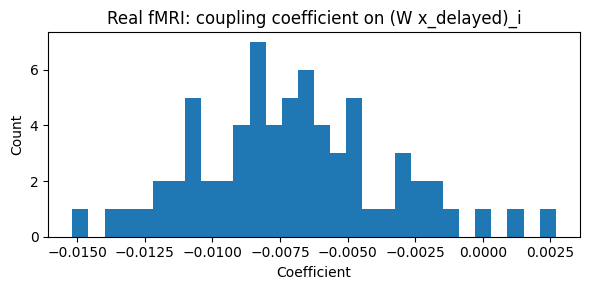

In [12]:
plt.figure(figsize=(6,3))
plt.hist(best["Xi"][:,3], bins=30)
plt.title("Real fMRI: coupling coefficient on (W x_delayed)_i")
plt.xlabel("Coefficient")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


In [13]:
Xi = best["Xi"]
print("Coeff stats:")
for k, name in enumerate(["1","x","x^3","Wx_delay"]):
    print(name, "mean|.| =", float(np.mean(np.abs(Xi[:,k]))),
          "max|.| =", float(np.max(np.abs(Xi[:,k]))))


Coeff stats:
1 mean|.| = 2.503377946516152e-05 max|.| = 0.0008713418772017824
x mean|.| = 0.012836501516290648 max|.| = 0.06442822390898648
x^3 mean|.| = 0.19562181457641756 max|.| = 0.9697548259198656
Wx_delay mean|.| = 0.007173237077899709 max|.| = 0.015172800242094456


local -> best lam: 0.1 val_mse: 0.0005695876269413731
net -> best lam: 0.000825404185268019 val_mse: 0.0005297521916076158
full -> best lam: 0.000825404185268019 val_mse: 0.0005297505549187247


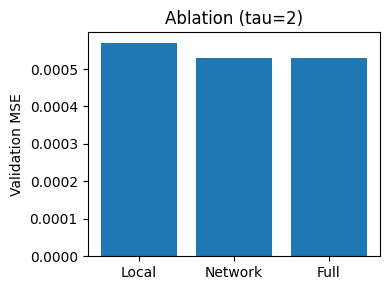


--- LOCAL coeff stats ---
Coeff stats:
1          mean|.| = 0  max|.| = 0
x          mean|.| = 0  max|.| = 0
x^3        mean|.| = 0.0138721  max|.| = 0.205859

--- NET coeff stats ---
Coeff stats:
1          mean|.| = 1.2633e-05  max|.| = 0.000859047
Wx_delay_norm mean|.| = 0.00687811  max|.| = 0.014776

--- FULL coeff stats ---
Coeff stats:
1          mean|.| = 2.50338e-05  max|.| = 0.000871342
x          mean|.| = 0.0128365  max|.| = 0.0644282
x^3        mean|.| = 0.195622  max|.| = 0.969755
Wx_delay_norm mean|.| = 0.00717324  max|.| = 0.0151728


In [17]:
# ============================
# ABLATION (LOCAL vs NET vs FULL)
# Paste this as a block near the end of your notebook,
# AFTER you already have:
#   - delay_shift(...)
#   - stlsq(...)
#   - lam_grid defined
#   - Xtr, dXtr, Xva, dXva, W defined
# ============================

import numpy as np
import matplotlib.pyplot as plt

# ---------- A1) Ablation feature builder ----------
def build_theta_ablation(i, Xseg, W, tau, mode="full"):
    """
    mode:
      'local' -> [1, x_i, x_i^3]
      'net'   -> [1, (W x(t-tau))_i]  with columnwise normalization of Wx
      'full'  -> [1, x_i, x_i^3, (W x(t-tau))_i] with normalization
    """
    xd = delay_shift(Xseg, tau)
    Wx = xd @ W.T                         # (Tseg, N)
    Wx_n = Wx / (Wx.std(axis=0, keepdims=True) + 1e-8)  # normalize columns

    xi = Xseg[:, i]

    if mode == "local":
        Theta = np.column_stack([np.ones(len(xi)), xi, xi**3])
    elif mode == "net":
        Theta = np.column_stack([np.ones(len(xi)), Wx_n[:, i]])
    elif mode == "full":
        Theta = np.column_stack([np.ones(len(xi)), xi, xi**3, Wx_n[:, i]])
    else:
        raise ValueError("mode must be 'local', 'net', or 'full'")

    return Theta


# ---------- A2) Fit all nodes for a given mode ----------
def fit_all_nodes_ablation(Xseg, dXseg, W, tau, lam, mode, max_iter=10):
    """
    Returns Xi_all with shape (N, p), where p depends on mode.
    """
    Tseg, N = Xseg.shape
    p = build_theta_ablation(0, Xseg, W, tau, mode).shape[1]
    Xi_all = np.zeros((N, p), dtype=float)

    for i in range(N):
        Theta_i = build_theta_ablation(i, Xseg, W, tau, mode)
        Xi_all[i] = stlsq(Theta_i, dXseg[:, i], lam=float(lam), max_iter=max_iter)

    return Xi_all


# ---------- A3) Validate (must match the SAME library as fitting) ----------
def val_mse_ablation(Xseg, dXseg, W, tau, Xi_all, mode):
    Tseg, N = Xseg.shape
    dXhat = np.zeros_like(dXseg)

    for i in range(N):
        Theta_i = build_theta_ablation(i, Xseg, W, tau, mode)
        dXhat[:, i] = Theta_i @ Xi_all[i]

    return float(np.mean((dXseg - dXhat)**2))


# ---------- A4) Run ablation sweep at fixed tau (use your best tau, e.g. 2) ----------
tau_fixed = 2  # set to your best tau from the full real-fMRI sweep
modes = ["local", "net", "full"]
ablation_results = {}

for mode in modes:
    best = {"val_mse": np.inf, "lam": None, "Xi": None}
    for lam in lam_grid:
        Xi = fit_all_nodes_ablation(Xtr, dXtr, W, tau=tau_fixed, lam=lam, mode=mode, max_iter=10)
        mse = val_mse_ablation(Xva, dXva, W, tau=tau_fixed, Xi_all=Xi, mode=mode)
        if mse < best["val_mse"]:
            best = {"lam": float(lam), "val_mse": float(mse), "Xi": Xi}
    ablation_results[mode] = best
    print(mode, "-> best lam:", best["lam"], "val_mse:", best["val_mse"])


# ---------- A5) Plot ablation comparison ----------
plt.figure(figsize=(4,3))
plt.bar(["Local", "Network", "Full"],
        [ablation_results["local"]["val_mse"],
         ablation_results["net"]["val_mse"],
         ablation_results["full"]["val_mse"]])
plt.ylabel("Validation MSE")
plt.title(f"Ablation (tau={tau_fixed})")
plt.tight_layout()
plt.show()


# ---------- A6) Optional: coefficient stats for each mode ----------
def coeff_stats(Xi, names):
    print("Coeff stats:")
    for k, name in enumerate(names):
        print(f"{name:10s} mean|.| = {float(np.mean(np.abs(Xi[:,k]))):.6g}  max|.| = {float(np.max(np.abs(Xi[:,k]))):.6g}")

print("\n--- LOCAL coeff stats ---")
coeff_stats(ablation_results["local"]["Xi"], ["1", "x", "x^3"])

print("\n--- NET coeff stats ---")
coeff_stats(ablation_results["net"]["Xi"], ["1", "Wx_delay_norm"])

print("\n--- FULL coeff stats ---")
coeff_stats(ablation_results["full"]["Xi"], ["1", "x", "x^3", "Wx_delay_norm"])



In [18]:
subject_results = []

for s in range(S):
    Xs = TSz[s]        # (T,N)
    dXs = savgol_derivative(Xs, dt)

    Xtr_s, Xva_s = Xs[:split], Xs[split:]
    dXtr_s, dXva_s = dXs[:split], dXs[split:]

    best = {"tau": None, "lam": None, "val_mse": np.inf}

    for tau in [0,1,2,3]:
        for lam in lam_grid:
            Xi = fit_all_nodes_mode(Xtr_s, dXtr_s, W, tau, lam, mode="full")
            mse = val_mse_global(Xva_s, dXva_s, W, tau, Xi)
            if mse < best["val_mse"]:
                best = {"tau": tau, "lam": lam, "val_mse": mse}

    subject_results.append(best)
    print(f"subj {s}: tau={best['tau']} mse={best['val_mse']:.4g}")


subj 0: tau=2 mse=0.0173
subj 1: tau=2 mse=0.02386
subj 2: tau=3 mse=0.03238
subj 3: tau=2 mse=0.02775
subj 4: tau=2 mse=0.02164
subj 5: tau=2 mse=0.02427
subj 6: tau=2 mse=0.033
subj 7: tau=2 mse=0.02457
subj 8: tau=2 mse=0.02556
subj 9: tau=3 mse=0.02573
subj 10: tau=2 mse=0.0269
subj 11: tau=2 mse=0.02168
subj 12: tau=3 mse=0.02773
subj 13: tau=2 mse=0.02234
subj 14: tau=2 mse=0.02803
subj 15: tau=2 mse=0.02079
subj 16: tau=2 mse=0.02886
subj 17: tau=2 mse=0.02601
subj 18: tau=2 mse=0.01667
subj 19: tau=2 mse=0.02682
subj 20: tau=2 mse=0.0205
subj 21: tau=2 mse=0.0251
subj 22: tau=3 mse=0.02681
subj 23: tau=2 mse=0.01687
subj 24: tau=2 mse=0.02553
subj 25: tau=2 mse=0.02937
subj 26: tau=2 mse=0.01966
subj 27: tau=3 mse=0.02881
subj 28: tau=2 mse=0.01834
subj 29: tau=2 mse=0.02628
subj 30: tau=2 mse=0.01799
subj 31: tau=2 mse=0.02747
subj 32: tau=2 mse=0.02509
subj 33: tau=2 mse=0.02399
subj 34: tau=3 mse=0.0259
subj 35: tau=3 mse=0.0272
subj 36: tau=2 mse=0.03274
subj 37: tau=2 mse=

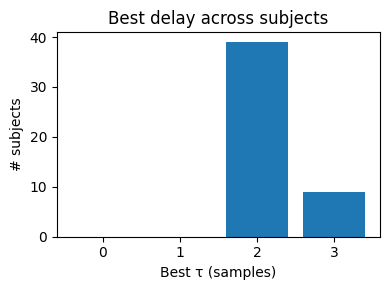

In [19]:
taus = [r["tau"] for r in subject_results]

plt.figure(figsize=(4,3))
plt.hist(taus, bins=np.arange(-0.5,4.5,1), rwidth=0.8)
plt.xlabel("Best τ (samples)")
plt.ylabel("# subjects")
plt.title("Best delay across subjects")
plt.tight_layout()
plt.show()
